In [1]:
import mask
import numpy as np
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from field_importer import get_field
import tqdm
import xarray as xr
from calendar import monthrange
import warnings
from scipy.spatial import Delaunay
import os
from importlib import reload
import pickle
from cartoplot import cartoplot
import ll_xy
from regrid import regrid
from mpl_toolkits.basemap import Basemap
from ll_xy import lonlat_to_xy

import sys
sys.path.append('..')

import tools
reload(tools)

from tools import qplot
reload(ll_xy)

from ll_xy import lonlat_to_xy
import shapely
from shapely.geometry import Point, LineString

%config Completer.use_jedi = False

/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


# Wrangle concentration data

In [2]:
d = Dataset('/media/robbie/TOSHIBA EXT/OSISAF_conc/ice_conc_nh_ease-125_multi_201902021200.nc')
d

FileNotFoundError: [Errno 2] No such file or directory: b'/media/robbie/TOSHIBA EXT/OSISAF_conc/ice_conc_nh_ease-125_multi_201902021200.nc'

In [3]:
d = Dataset('/media/robbie/TOSHIBA EXT/OSISAF_conc/2010/01/ice_conc_nh_polstere-100_multi_201001101200.nc')
d

FileNotFoundError: [Errno 2] No such file or directory: b'/media/robbie/TOSHIBA EXT/OSISAF_conc/2010/01/ice_conc_nh_polstere-100_multi_201001101200.nc'

In [18]:
smos_base_dir = '/media/robbie/TOSHIBA EXT/awi_cs2_smos'

smos_file_preamble = '/W_XX-ESA,SMOS_CS2,NH_25KM_EASE2_'

smos_file_backend = '_r_v203_01_l4sit.nc'

smos_latest_file_dir = '/media/robbie/TOSHIBA EXT/awi_cs2_smos/LATEST'

smos_original_backend = '_o_v203_01_l4sit.nc'


#########################

vecs_base_dir = '/media/robbie/TOSHIBA EXT/OSISAF_vectors/merged'

vecs_file_preamble = 'ice_drift_nh_polstere-625_multi-oi_'

#########################

one_day = datetime.timedelta(days=1)

def get_awi_smos_raw(date):
    
    three_days = datetime.timedelta(days=3)
    
    start_date = date - three_days
    end_date = date + three_days
    
    file_dir = f'{smos_base_dir}/{date.year}/{str(date.month).zfill(2)}'
    
    file_date_bit = f'{start_date.year}{str(start_date.month).zfill(2)}{str(start_date.day).zfill(2)}_{end_date.year}{str(end_date.month).zfill(2)}{str(end_date.day).zfill(2)}'
    
    file_name = smos_file_preamble + file_date_bit + smos_file_backend
    
    try:
        d = Dataset(f'{file_dir}{file_name}')
        
    except:
        
        print(file_name)
        
        d = Dataset(f'{smos_latest_file_dir}{smos_file_preamble}{file_date_bit}{smos_original_backend}')

    
    return(d)


def get_OSI_vecs_raw(date):
    
    try:
    
        start_date = date - one_day
        end_date = date + one_day

        file_date_bit = f'{start_date.year}{str(start_date.month).zfill(2)}{str(start_date.day).zfill(2)}1200-{end_date.year}{str(end_date.month).zfill(2)}{str(end_date.day).zfill(2)}1200'

        file_dir = f'{vecs_base_dir}/{date.year}/{str(date.month).zfill(2)}/{vecs_file_preamble}{file_date_bit}.nc'

        d = Dataset(file_dir)
        
    except:
        
        date = date + one_day
        
        start_date = date - one_day
        end_date = date + one_day

        file_date_bit = f'{start_date.year}{str(start_date.month).zfill(2)}{str(start_date.day).zfill(2)}1200-{end_date.year}{str(end_date.month).zfill(2)}{str(end_date.day).zfill(2)}1200'

        file_dir = f'{vecs_base_dir}/{date.year}/{str(date.month).zfill(2)}/{vecs_file_preamble}{file_date_bit}.nc'

        d = Dataset(file_dir)
    
    return(d)

def transform(angle_deg, u, v):
    rad_45 = np.radians(angle_deg)
    u = u*np.cos(rad_45) - v*np.sin(rad_45)
    v = v*np.cos(rad_45) + u*np.sin(rad_45)
    return(u,v)
    
   

# Test plot some OSISAF vectors

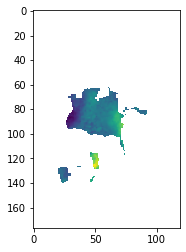

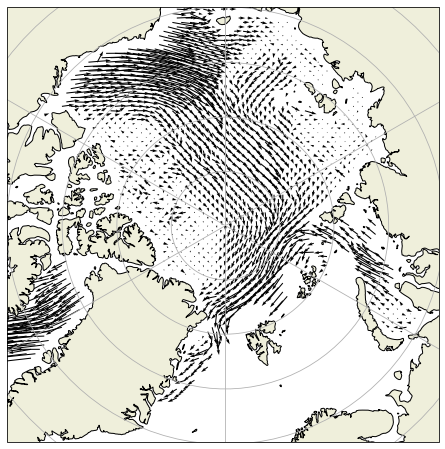

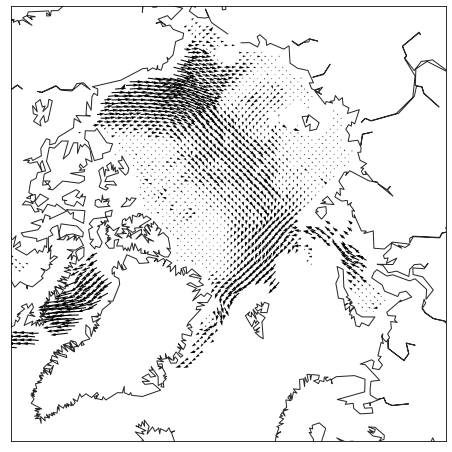

In [5]:
test_date = datetime.date(year=2014,month=2,day=27)

vec_data = get_OSI_vecs_raw(test_date)

plt.imshow(vec_data['dY'][0])

osi_lons, osi_lats = np.array(vec_data['lon']), np.array(vec_data['lat'])

vec_data['dX']

dX = np.ma.filled(vec_data['dX'][0],np.nan)
dY = np.ma.filled(vec_data['dY'][0],np.nan)

dX, dY = transform(-45,dX, -dY)

qplot(osi_lons,osi_lats,dX,dY,scale=500,s=1,figsize=(8,8))

plt.figure(figsize=(8,8))

m = Basemap(projection="npstere", boundinglat = 66,  lon_0 = 0)

m.drawcoastlines(color = '0.15')

s=1

m.quiver(osi_lons[::s,::s], osi_lats[::s,::s], dX[::s,::s],
         dY[::s,::s], latlon=True, angles='xy',scale=1000)

plt.show()

# Plot some AWI thickness data

--
nan


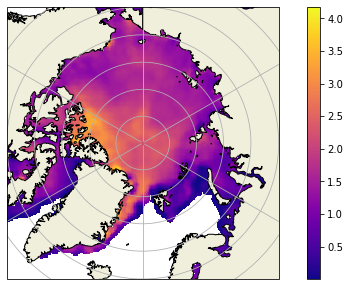

In [6]:
test_date = datetime.date(year=2011,month=2,day=16)

data = get_awi_smos_raw(test_date)

sit = data['analysis_sea_ice_thickness'][0]

print(sit[0,0])

sit = np.ma.filled(sit, np.nan)

print(sit[0,0])

ease2_lons, ease2_lats = np.array(data['lon']), np.array(data['lat'])

ease1_lons, ease1_lats = mask.get('lon'), mask.get('lat')

cartoplot(ease2_lons,ease2_lats, sit)

In [7]:
import pyproj as proj
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator

args = proj.Proj(proj="aeqd", lat_0=90, lon_0=0, datum="WGS84", units="m")

crs_wgs = proj.Proj(init='epsg:4326')  # assuming you're using WGS84 geographic

xout, yout = proj.transform(crs_wgs, args, np.array(ease1_lons),np.array(ease1_lats))

xin, yin = proj.transform(crs_wgs, args, np.array(osi_lons),np.array(osi_lats))

points = np.column_stack((xin.ravel(),yin.ravel()))

tri = Delaunay(points)  # Compute the triangulation


/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-

In [12]:
winter_months = ['12','01','02']

# ease1_data = {}

# years = np.arange(2010,2022)

years = [2021]

for year in tqdm.tqdm(years):
    
    ease1_data[year] = {}
    
    if year == 2010: months = ['12']
    elif year == 2021: months = ['01','02']
    else: months = winter_months
    
    for month in months:
        
        days_in_month = monthrange(year,int(month))[1]
        
        if (month == '02') & (year == 2021): days_in_month = 28
        
        sit_array_to_fill = np.full((days_in_month,361,361), np.nan)
        dX_array_to_fill = np.full((days_in_month,361,361), np.nan)
        dY_array_to_fill = np.full((days_in_month,361,361), np.nan)
        
        for middle_dom in np.arange(1,days_in_month+1):
            
            middle_date = datetime.date(year=year,month=int(month),day=middle_dom)
            
            vec_data = get_OSI_vecs_raw(middle_date)
            
            dX, dY = np.ma.filled(vec_data['dX'][0], np.nan), np.ma.filled(vec_data['dY'][0], np.nan)
            
            if year < 2015: dY = -dY
            elif (year == 2015) and (int(month) < 5): dY = -dY
            
            dXr,dYr = transform(-45,dX,dY)
            
            interpolator = LinearNDInterpolator(tri, dXr.ravel())
            dX_array_to_fill[middle_dom-1] = interpolator((xout,yout))

            interpolator = LinearNDInterpolator(tri, dYr.ravel())
            dY_array_to_fill[middle_dom-1] = interpolator((xout,yout))

            sit_data = get_awi_smos_raw(middle_date)
            ease2_sit = sit_data['analysis_sea_ice_thickness'][0]
            ease2_sit = np.ma.filled(ease2_sit, np.nan)
            
            for f in [dXr, dYr, ease2_sit]:
                if ~np.isnan(f[0,0]):
                    print(month,year)
                    print(f[0,0])
                    cartoplot(osi_lons, osi_lats, f)
                    
                    raise
            
            
            sit_array_to_fill[middle_dom-1] = regrid(ease2_sit,ease2_lons,ease2_lats,ease1_lons,ease1_lats, method='nearest')
            
            
        ease1_data[year][month] = {'sit':sit_array_to_fill,
                                   'dX':dX_array_to_fill,
                                   'dY':dY_array_to_fill,
                                   'days_in_month':days_in_month}
            


  0%|          | 0/1 [00:00<?, ?it/s]

/W_XX-ESA,SMOS_CS2,NH_25KM_EASE2_20201231_20210106_r_v203_01_l4sit.nc
/W_XX-ESA,SMOS_CS2,NH_25KM_EASE2_20210101_20210107_r_v203_01_l4sit.nc
/W_XX-ESA,SMOS_CS2,NH_25KM_EASE2_20210102_20210108_r_v203_01_l4sit.nc
/W_XX-ESA,SMOS_CS2,NH_25KM_EASE2_20210205_20210211_r_v203_01_l4sit.nc
/W_XX-ESA,SMOS_CS2,NH_25KM_EASE2_20210224_20210302_r_v203_01_l4sit.nc


100%|██████████| 1/1 [00:17<00:00, 17.45s/it]


In [17]:
processed_dir = '/media/robbie/TOSHIBA EXT/awi_cs2_smos/processed'

years = np.arange(2010,2022)

for year in tqdm.tqdm(years):
    
    if year == 2010: months = ['12']
    elif year == 2021: months = ['01','02']
    else: months = winter_months
    
    for month in months:
        
        sit = ease1_data[year][month]['sit']
        dXr = ease1_data[year][month]['dX']
        dYr = ease1_data[year][month]['dY']
        
#         cartoplot(ease1_lons, ease1_lats, sit[-5])
        
        dim = ease1_data[year][month]['days_in_month']
        
        ds = xr.Dataset( data_vars={'sit':(['dom','x','y'],sit),
                                    'dXr':(['dom','x','y'],dXr),
                                    'dYr':(['dom','x','y'],dYr)},

                         coords =  {'lon':(['x','y'],ease1_lons),
                                    'lat':(['x','y'],ease1_lats),
                                    'day_of_month':(['dom'],np.arange(1,dim+1))})

        ds.to_netcdf(f'{processed_dir}/{year}{str(month).zfill(2)}.nc')

100%|██████████| 12/12 [00:27<00:00,  2.26s/it]
